In [24]:
# import networkx
import rustworkx as rx
from rustworkx.visualization import graphviz_draw
from rustworkx.visualization import mpl_draw
import networkx as nx
import lovelyplots
import scienceplots
from corral_crowding.module_graph import QuantumModuleGraph

In [25]:
from corral_crowding.detuning_fit import compute_infidelity_parameters, decay_fit
import numpy as np


class GateFidelityOptimizer:
    """Computes infidelity contributions and cost function for a given QuantumModuleGraph."""

    def __init__(self, module_graph, lambdaq=0.08, eta=1.8, alpha=120e6, g3=60e6):
        """Initializes the optimizer and precomputes infidelity parameters.

        Args:
            module_graph (QuantumModuleGraph): The quantum module to optimize.
            lambdaq, eta, alpha, g3: Physical parameters for infidelity computations.
        """
        self.module_graph = module_graph

        # Compute infidelity parameters once
        detuning_list = np.linspace(50, 1000, 64)
        self.infidelity_params, _ = compute_infidelity_parameters(
            detuning_list, lambdaq, eta, alpha, g3
        )

    def _unit_crosstalk(self, intended_freq, spectator_key, spectator_freq):
        """Compute infidelity contribution from a single spectator interaction."""
        distance = np.abs(intended_freq - spectator_freq)
        units_distance = distance * 1e3  # Convert GHz → MHz

        # Apply smoothing approximations
        if distance < 0.05:
            return 3  # Strong crosstalk penalty
        if distance > 0.6:
            return 0  # Negligible impact

        # Retrieve fit parameters for the interaction type
        params = self.infidelity_params.get(spectator_key)
        if params is None:
            raise KeyError(f"Unknown interaction type: {spectator_key}")

        a, b, c, d = params
        return decay_fit(units_distance, a, b, c, d)

    def compute_gate_infidelity(self, edge):
        """Computes the infidelity of a single driven two-qubit gate."""
        interaction_data = self.module_graph.get_interaction_frequencies()
        driven_freq = interaction_data["qubit-qubit"][edge]
        gate_infidelity = 0.0

        # Iterate over all relevant interaction types
        for interaction_type in ["qubit-qubit", "snail-qubit", "qubit-sub"]:
            for spectator_edge, spectator_freq in interaction_data[
                interaction_type
            ].items():
                if spectator_edge == edge:
                    continue  # Skip self-interaction
                gate_infidelity += self._unit_crosstalk(
                    driven_freq, interaction_type, spectator_freq
                )

        return gate_infidelity

    def compute_total_infidelity(self):
        """Computes total cost function by summing all gate infidelities."""
        interaction_data = self.module_graph.get_interaction_frequencies()
        gate_infidelities = {
            edge: self.compute_gate_infidelity(edge)
            for edge in interaction_data["qubit-qubit"]
        }

        return gate_infidelities, sum(gate_infidelities.values())

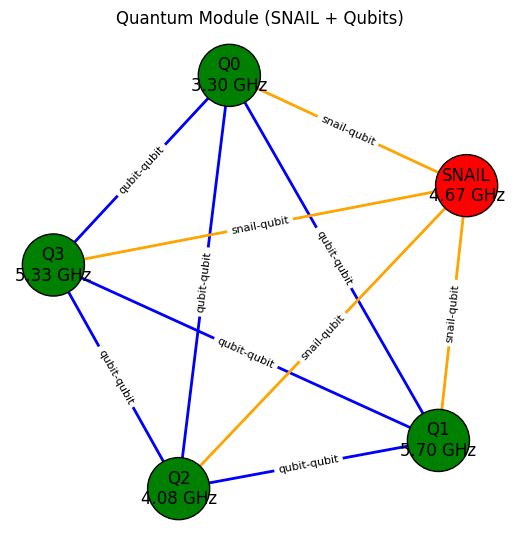

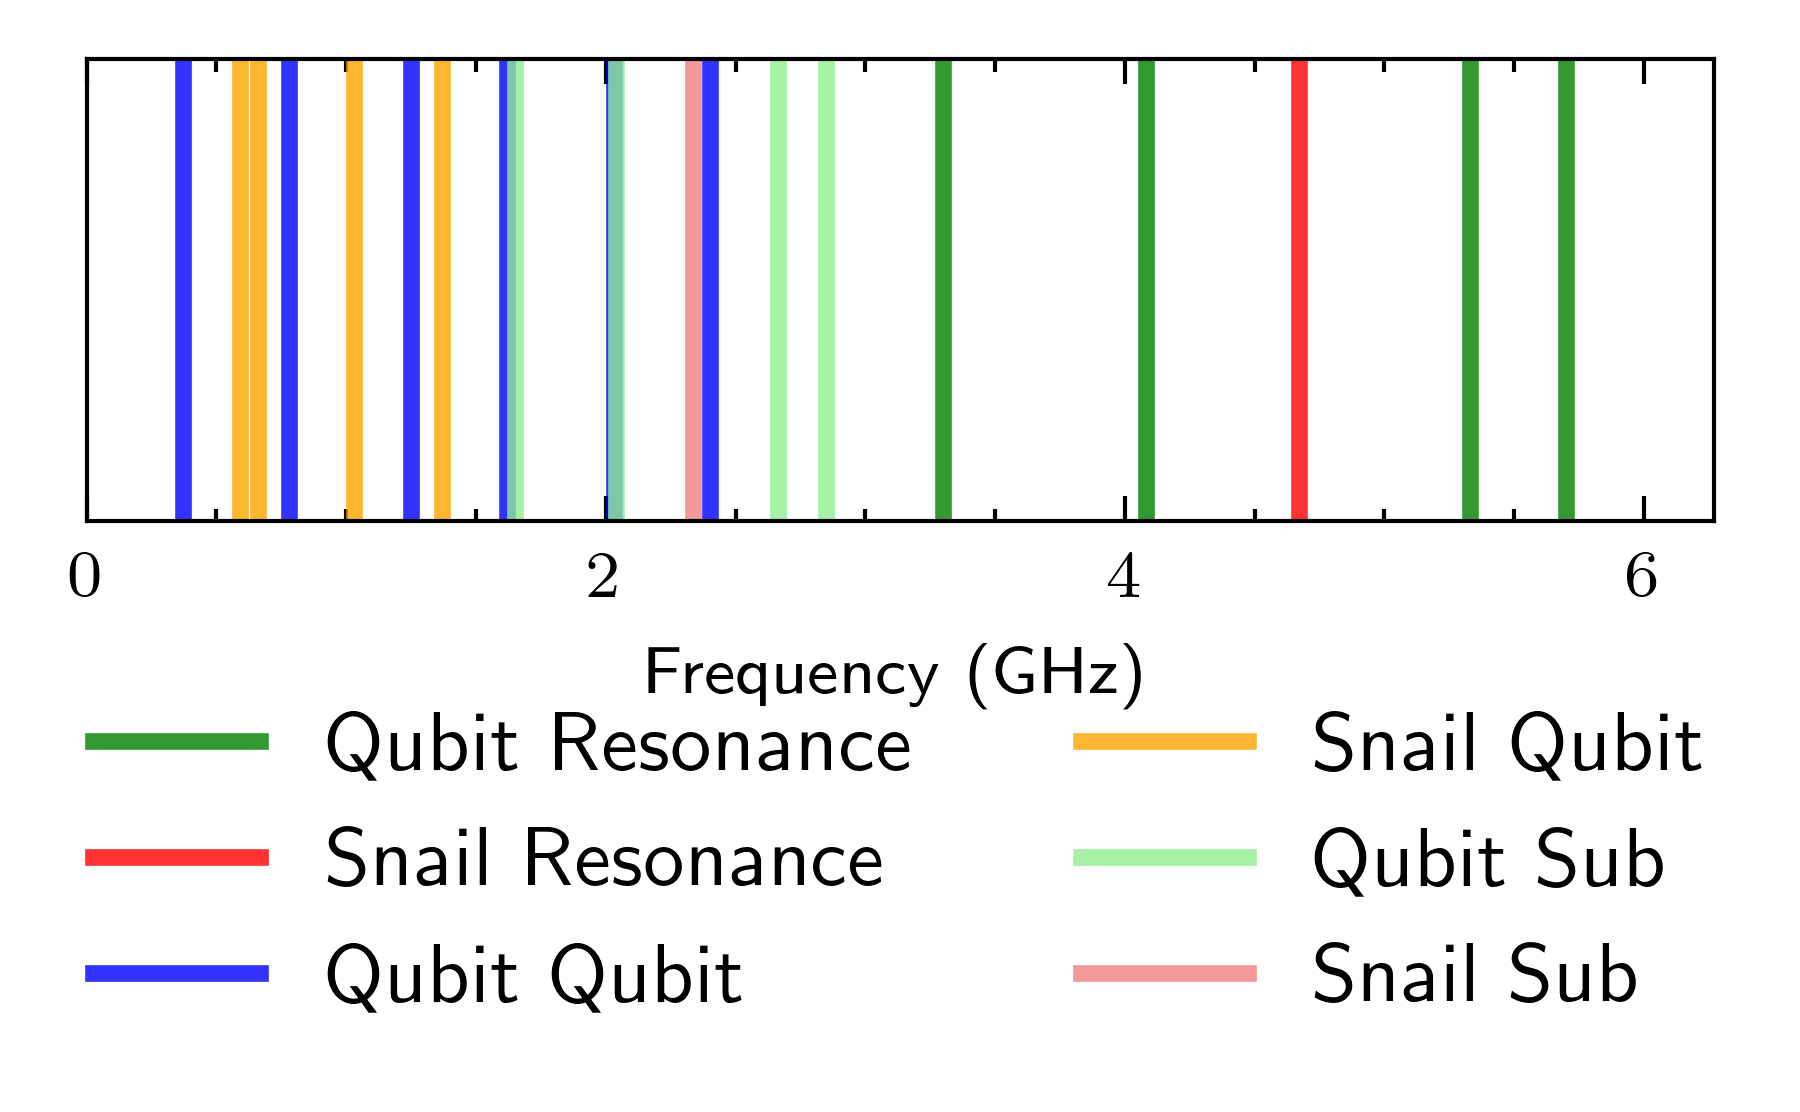

Gate Infidelities:
  Gate ('Q0', 'Q1') → Infidelity: 0.012925
  Gate ('Q0', 'Q2') → Infidelity: 0.207328
  Gate ('Q0', 'Q3') → Infidelity: 3.003342
  Gate ('Q1', 'Q2') → Infidelity: 3.036789
  Gate ('Q1', 'Q3') → Infidelity: 0.058651
  Gate ('Q2', 'Q3') → Infidelity: 0.168679

Total Gate Infidelity (Cost Function): 6.487716


/home/evm9/corral_crowding/src/corral_crowding/detuning_fit.py:28: RuntimeWarning: invalid value encountered in power
  return a * ((detuning + d) ** -b) + c


In [28]:
# Define qubit and SNAIL frequencies
bare_frequencies = [3.3, 5.7, 4.08, 5.33]  # GHz
snail_frequency = 4.67  # GHz

# Create a module graph
module = QuantumModuleGraph(bare_frequencies, snail_frequency)

# Plot the module (only showing qubit-qubit and snail-qubit interactions)
module.plot_graph()

module.get_interaction_frequencies()

module.plot_interaction_frequencies()

# Initialize the fidelity optimizer
optimizer = GateFidelityOptimizer(module)

# Compute total infidelity
gate_infidelities, total_infidelity = optimizer.compute_total_infidelity()

# Print results
print("Gate Infidelities:")
for edge, infidelity in gate_infidelities.items():
    print(f"  Gate {edge} → Infidelity: {infidelity:.6f}")

print(f"\nTotal Gate Infidelity (Cost Function): {total_infidelity:.6f}")